In [6]:
from Bio.PDB import PDBParser
import numpy as np
import gudhi
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from Bio.PDB.MMCIFParser import MMCIFParser

In [7]:
def create_df(structure):
    '''creates python data frame of data from .pdb files of 3D protein structures'''
    structure_list = []
    for model in structure: 
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_info = {
                        "Model": model.id,
                        "Chain": chain.id,
                        "Residue_Name": residue.get_resname(),
                        "Residue_ID": residue.get_id()[1],  # Sequence number
                        "Atom_Name": atom.get_name(),
                        "Element": atom.element,
                        "X": atom.coord[0],
                        "Y": atom.coord[1],
                        "Z": atom.coord[2]
                    }
                    structure_list.append(atom_info)
    df = pd.DataFrame(structure_list)
    return df

# Using Entire Point Cloud:

In [ ]:
# Sicklecell data 
# CRYSTAL STRUCTURE OF CARBONMONOXY HEMOGLOBIN S (LIGANDED SICKLE CELL HEMOGLOBIN) COMPLEXED WITH GBT440, CO-CRYSTALLIZATION EXPERIMENT
parser1 = PDBParser(QUIET=True)
sicklecell = parser1.get_structure("sicklecell", "data/5e83.pdb")
sicklecell_df = create_df(sicklecell)
sicklecell_point_cloud = sicklecell_df[['X', 'Y', 'Z']].to_numpy() # create point cloud (extract 3 dim coordinates)
sicklecell_rips_complex = gudhi.RipsComplex(points=sicklecell_point_cloud, max_edge_length=8.0) # create rips
sicklecell_simplex_tree = sicklecell_rips_complex.create_simplex_tree(max_dimension=3) # create simplex
sickle_diagram = sicklecell_simplex_tree.persistence(min_persistence=0.5) # create persistence diagram

In [8]:
# deoxygenated hemiglobin data
parser2 = PDBParser(QUIET=True)
deoxy = parser2.get_structure("deoxy", "data/1a3n.pdb") # deoxy
deoxy_df = create_df(deoxy)
deoxy_point_cloud = deoxy_df[['X', 'Y', 'Z']].to_numpy()
deoxy_rips_complex = gudhi.RipsComplex(points=deoxy_point_cloud, max_edge_length=8.0)  
deoxy_simplex_tree = deoxy_rips_complex.create_simplex_tree(max_dimension=3)
deoxy_diagram = deoxy_simplex_tree.persistence(min_persistence=0.5)

In [9]:
# oxygenated hemoglobin data
parser3 = MMCIFParser(QUIET=True)
oxy = parser3.get_structure("oxy1", "data/1hho-assembly1.cif")
oxy_df = create_df(oxy)
oxy1_df = oxy_df[oxy_df["Residue_Name"] != "OXY"] # remove oxygens from point cloud
oxy_point_cloud = oxy_df[['X', 'Y', 'Z']].to_numpy()
oxy_rips_complex = gudhi.RipsComplex(points=oxy_point_cloud, max_edge_length=8.0) 
oxy_simplex_tree = oxy_rips_complex.create_simplex_tree(max_dimension=3)
oxy_diagram = oxy_simplex_tree.persistence(min_persistence=0.5)

/Users/aliciabierly/anaconda3/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


Text(0.5, 1.0, 'Persistence Diagram Sickle')

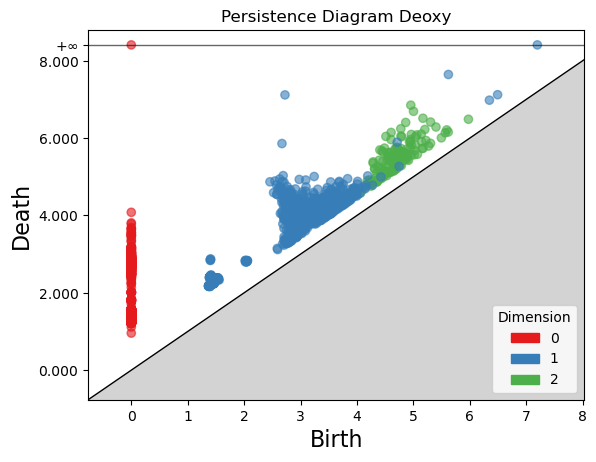

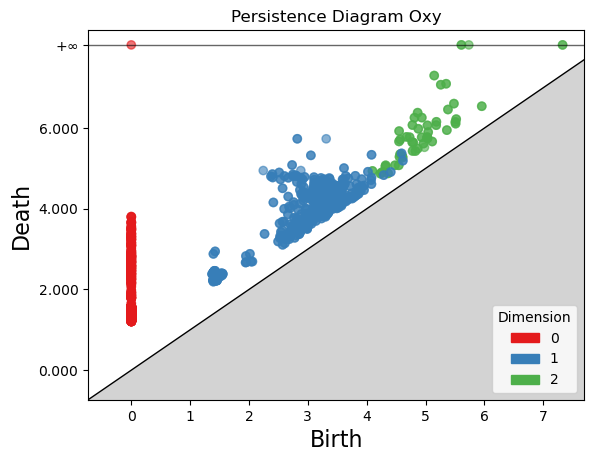

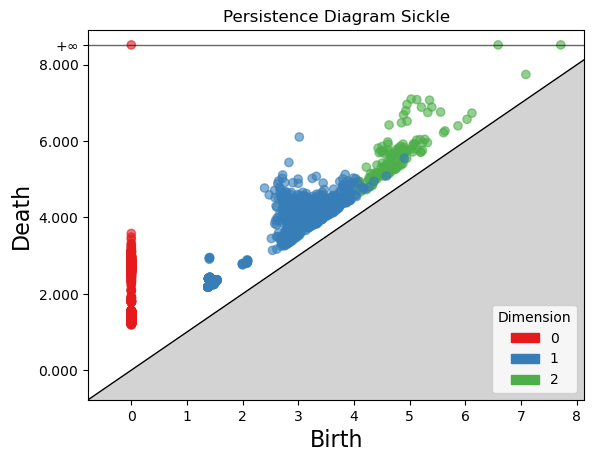

In [15]:
# create persistence diagrams (3 dimensions)
gudhi.plot_persistence_diagram(deoxy_diagram)
plt.title("Persistence Diagram Deoxy")

gudhi.plot_persistence_diagram(oxy_diagram)
plt.title("Persistence Diagram Oxy")

gudhi.plot_persistence_diagram(sickle_diagram)
plt.title("Persistence Diagram Sickle")

Text(0.5, 1.0, 'Persistence Barcode Sickle')

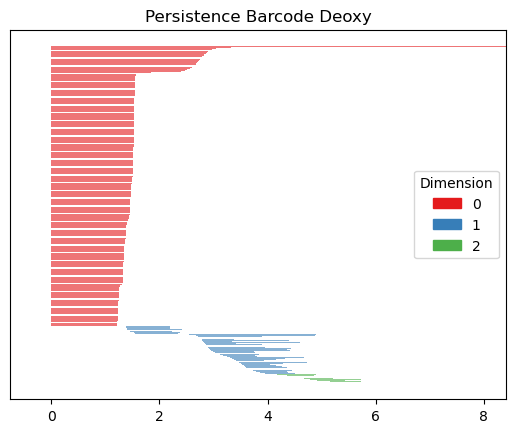

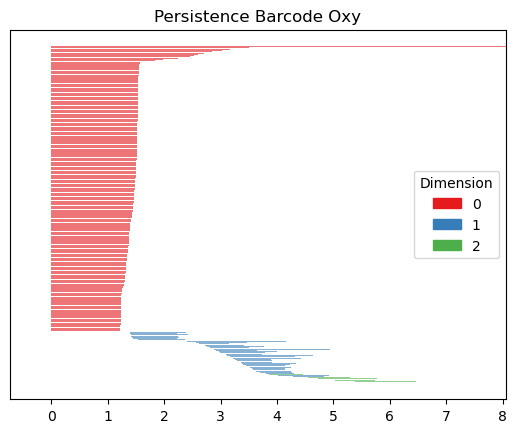

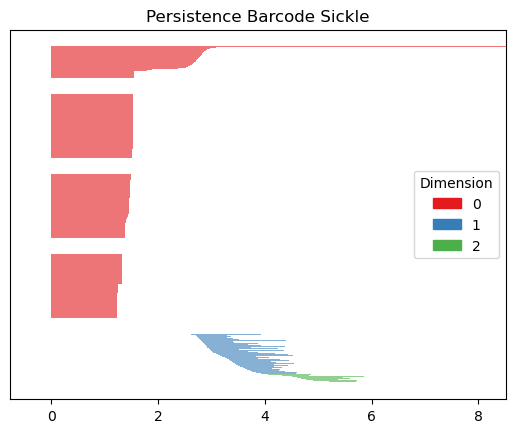

In [16]:
# create persistence barcodes (3 dimensions)
gudhi.plot_persistence_barcode(deoxy_diagram)
plt.title("Persistence Barcode Deoxy")

gudhi.plot_persistence_barcode(oxy_diagram)
plt.title("Persistence Barcode Oxy")

gudhi.plot_persistence_barcode(sickle_diagram)
plt.title("Persistence Barcode Sickle")

In [ ]:
# Bottleneck Distances
def bottleneck_distances(d1, d2, p=False, d1_name="", d2_name=""):
    distances = []
    for i in range(3):
        d1_pairs = np.array([pair for dim, pair in d1 if dim == i])
        d2_pairs = np.array([pair for dim, pair in d2 if dim == i])
        # get rid of inf values
        d1_noinf = d1_pairs[~np.isinf(d1_pairs).any(axis=1)]
        d2_noinf = d2_pairs[~np.isinf(d2_pairs).any(axis=1)]
        distances.append(gudhi.bottleneck_distance(d1_noinf, d2_noinf))
    if p == True:
        print(f"Bottleneck distances between {d1_name} and {d2_name}:")
        for i in range(3):
            print(f"\tDimension {i}:", distances[i])
    return distances

# want to compare oxygenated hemiglobin and sicklecell hemi because CO bound to sites on sicklecell, O2 bound on oxy sites
bottleneck_sickle_deoxy = bottleneck_distances(oxy_diagram, sickle_diagram, p=True, d1_name="deoxy hemoglobin", d2_name="sicklecell hemoglobin")
bottleneck_sickle_deoxy = bottleneck_distances(deoxy_diagram, oxy_diagram, p=True, d1_name="deoxy hemoglobin", d2_name="oxygenated hemoglobin")

Bottleneck distances between deoxy hemoglobin and sicklecell hemoglobin:
	Dimension 0: 1.1423795230558764
	Dimension 1: 0.6073384220479427
	Dimension 2: 0.3299873048157931
Bottleneck distances between deoxy hemoglobin and oxygenated hemoglobin:
	Dimension 0: 1.1514849480036637
	Dimension 1: 1.3829076665140612
	Dimension 2: 0.6686509901140765


# Using Residue Point Cloud:

In [8]:
parser1 = PDBParser(QUIET=True)
sicklecell = parser1.get_structure("sicklecell", "data/5e83.pdb")
sicklecell_df = create_df(sicklecell)
sicklecell_point_cloud = sicklecell_df.groupby("Residue_Name")[["X", "Y", "Z"]].mean().to_numpy() # create point cloud (extract 3 dim coordinates)
sicklecell_rips_complex = gudhi.RipsComplex(points=sicklecell_point_cloud, max_edge_length=10000000000) # create rips
sicklecell_simplex_tree = sicklecell_rips_complex.create_simplex_tree(max_dimension=3) # create simplex
sickle_diagram = sicklecell_simplex_tree.persistence(min_persistence=0.0000000001) # create persistence diagram

/Users/aliciabierly/anaconda3/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

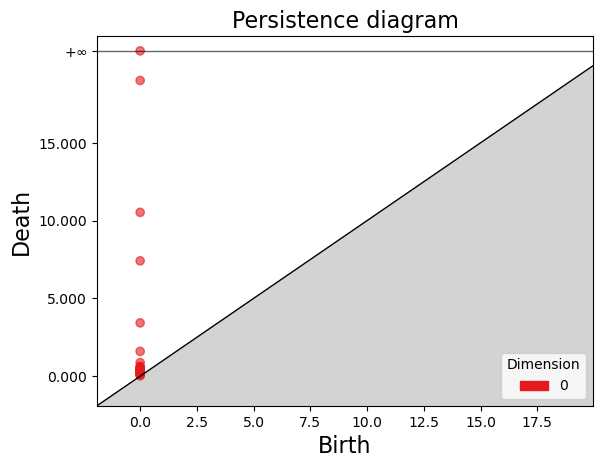

In [9]:
gudhi.plot_persistence_diagram(sickle_diagram)

In [10]:
sicklecell_point_cloud

array([[27.624666  , 11.604333  , 22.064499  ],
       [18.89404   ,  3.4391248 , 21.261135  ],
       [19.671507  ,  4.336187  , 21.35947   ],
       [17.494236  ,  2.2788625 , 21.20962   ],
       [19.213001  ,  3.6379707 , 21.22991   ],
       [16.55675   ,  1.4833751 , 21.2375    ],
       [13.784583  , -0.7738889 , 21.205944  ],
       [15.980737  ,  1.0422639 , 21.255056  ],
       [15.041126  ,  0.20682834, 21.22521   ],
       [15.646124  ,  0.77452505, 21.193031  ],
       [17.679277  , -9.134999  , 16.12839   ],
       [16.41736   ,  1.346186  , 21.239698  ],
       [15.554432  ,  0.71588224, 21.27781   ],
       [18.556261  ,  2.6361957 , 21.218369  ],
       [16.3211    ,  1.2854687 , 21.245089  ],
       [16.698187  ,  1.6032121 , 21.291689  ],
       [22.433334  ,  6.3620625 , 21.348251  ],
       [15.137717  ,  0.3279121 , 21.232454  ],
       [18.049025  ,  2.7506633 , 21.295444  ],
       [19.41198   ,  3.854479  , 21.315084  ],
       [16.303179  ,  1.2728974 , 21.248

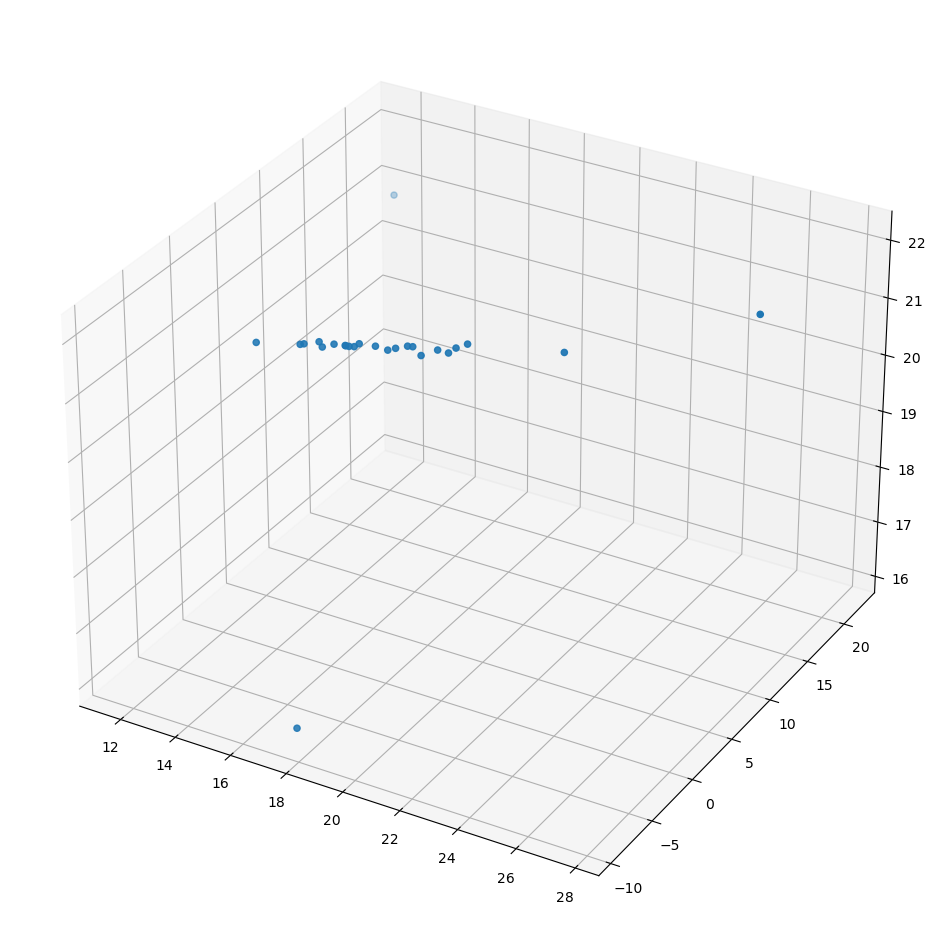

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(sicklecell_point_cloud[:, 0], sicklecell_point_cloud[:, 1], sicklecell_point_cloud[:, 2])
plt.show()

In [17]:
sicklecell_point_cloud[:, 0]

array([27.624666, 18.89404 , 19.671507, 17.494236, 19.213001, 16.55675 ,
       13.784583, 15.980737, 15.041126, 15.646124, 17.679277, 16.41736 ,
       15.554432, 18.556261, 16.3211  , 16.698187, 22.433334, 15.137717,
       18.049025, 19.41198 , 16.303179, 18.193655, 17.720423, 11.651777,
       17.122599], dtype=float32)